# <ins>Predicting Poetic Movements</ins>

## Modeling

### Using Naive Bayes, Decision Tree, Random Forest, and SVM

### NOTE: Currently working on revamping/organizing. Thank you for understanding :)

## Table of contents

1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Preparing the data](#Step-1:-Preparing-the-data)
    
    - [Multicollinearity](#Multicollinearity)
    - [Dealing with outliers](#Dealing-with-outliers)
    - [Save/Load DataFrame](#💾-Save/Load-DataFrame)
    - [Train-test split](#Train-test-split)
    - [Vectors DataFrame](#Vectors-DataFrame)
    - [Combo DataFrame](#Combo-DataFrame)
    
    
5. [Step 2: Modeling](#Step-2:-Modeling)

    - [Bernoulli Naive Bayes](#Bernoulli-Naive-Bayes)
    - [K-Nearest Neighbors](#K-Nearest-Neighbors)
    - [Decision Tree](#Decision-Tree)
    - [Random Forest](#Random-Forest)
    - [SVM](#SVM)

    - [Parameter tuning](#Parameter-tuning)
    - [Train final model](#Train-final-model)
    
    
6. [Step 3: Reproducibility](#Step-3:-Reproducibility)

    - [NLP + Model version](#NLP-+-Model-version)
    - [Model only version](#Model-only-version)
    
    
7. [Conclusions](#Conclusions)
8. [Acknowledgements](#Acknowledgements)

## Introduction

[[go back to the top](#Predicting-Poetic-Movements)]

After [scraping](01_webscraping.ipynb) PoetryFoundation.org for genre-labeled poems and [cleaning](02_data_cleaning.ipynb), I used [natural language processing (NLP)](03_nlp_features_eda.ipynb) techniques to analyze poetic structure across poetic genres and movements. 

Through text processing, exploratory data analysis, and feature engineering, I looked for insights into how poetic structure, word usage, lexical richness, and sentiment relate to the genre of a poem.

In this notebook, I will create predictive models that classify poems into one of four umbrella movements: *Avant-Garde*, *Metropolitan*, *Modern*, or *Pre-1900*. This will help provide further insight and confirm my findings during EDA.

The ultimate goal is to create a recommendation system that compares poem similarities and recommends individual poems to users. *(NOTE: To skip to the recommendation system notebook, click [here](05_recommendation_system.ipynb))*.

## The problem domain

[[go back to the top](#Predicting-Poetic-Movements)]

Within written media, poetry is often regarded as enigmatic, frivolous, or too niche. As a result, poems (even by established poets) are often overlooked by larger publishers and literature-focused websites alike. (The anti-capitalist nature of poetry may play a role here as well). There are services for rating and recommending entire books (including poetry collections, to be fair) like GoodReads, Amazon, or Bookish, but to my knowledge, there aren't any sites or services that recommend poems on an individual level.

With this in mind, I wondered how poem recommendation may even work. One often finds a genre or two that they like and searches that out, but there must be elements of poetry that transcend genre. If there are, machine learning seems like a perfect tool to use to find them. As a poet and writer, I am interested in creating something that will allow me to discover genres and movements that I may have previously ignored. I can do this by using poems I already know and enjoy to find similar poems from genres I may not know as well.

## Required libraries

[[go back to the top](#Predicting-Poetic-Movements)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. Libraries within this category that I'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **scipy**: The essential statistical analysis package in Python.
- **collections**: A package with specialized and higher-performance data structures.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:

- **nltk**: The essential natural language processing package.
- **gensim**: A more specialized natural language processing package.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[functions](functions.py)**: Custom functions that I built for this project.

Required within the functions file are:
- **itertools**: An package aiding in advanced iteration techniques.
- **regex**: The essential string matching and capturing package.
- **string**: A package with string-specific operations and characters.
- **pronouncing**: A package utilizing the CMU Pronouncing Dictionary that can break language down by syllable, rhyme, and meter.
- **textblob**: A supplementary package to enhance the nltk package.

In [84]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

# text processing
# from nltk import RegexpTokenizer
# from gensim import matutils, models\
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# from keras.models import Sequential
# from keras.layers import Dense, LSTM, Bidirectional
# from keras.layers.embeddings import Embedding
# from keras.preprocessing import sequence

# miscellany
import time
from tqdm import tqdm
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore sklearn/tensorflow warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Step 1: Preparing the data

[[go back to the top](#Predicting-Poetic-Movements)]

- Look for any highly correlated variables, to fight against the curse of dimensionality.
- Deal with any outlier data.

#### 💾 Load DataFrame

In [2]:
# uncomment to load
with gzip.open('data/poetry_movements_df.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [3]:
df.columns

Index(['poet', 'poem_url', 'title', 'poem_lines', 'poem_string', 'genre',
       'movement', 'clean_lines', 'num_lines', 'lines_titled', 'num_words',
       'avg_len_line', 'string_titled', 'sentiment_polarity_score',
       'sentiment_polarity', 'sentiment_subjectivity_score', 'num_end_rhymes',
       'end_rhyme_ratio', 'end_rhyme', 'avg_syllables_word',
       'lexical_richness', 'string_cleaned'],
      dtype='object')

In [4]:
# check out the class balance
df.movement.value_counts(normalize=True)

modern          0.288832
metropolitan    0.248665
pre_1900        0.240771
avant_garde     0.221732
Name: movement, dtype: float64

### Multicollinearity

[[go back to the top](#Predicting-Poetic-Movements)]

In [5]:
# list of continuous variables
cont_cols = [
    'num_lines', 'num_words', 'avg_len_line', 
    'sentiment_polarity_score', 'sentiment_subjectivity_score', 
    'num_end_rhymes', 'end_rhyme_ratio', 'avg_syllables_word', 
    'lexical_richness'
]

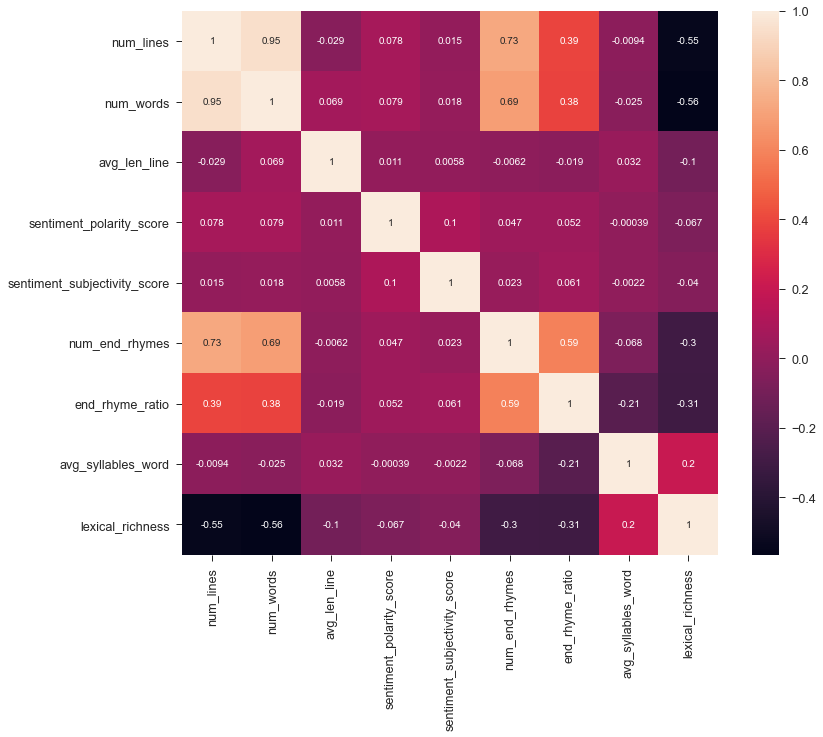

In [6]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

- As seen in the [previous notebook](03_nlp_features_eda.ipynb), the number of lines (```num_lines```) and number of words (```num_words```) in a poem are very highly correlated.
    - I'll drop ```num_words```, as the number of lines is a more widely used metric for the length of a poem.
- The number of end rhymes (```num_end_rhymes```) is also rather highly correlated with ```num_lines```, so it's worth considering dropping that.
    - I found the ratio of end rhymes to the number of lines (```end_rhyme_ratio```) to be more statistically significant than the number of end rhymes, so I'd prefer to use that as my end rhyme metric anyway.

In [7]:
# new list of continuous variables
cont_cols = [
    'num_lines', 'avg_len_line', 'sentiment_polarity_score', 
    'sentiment_subjectivity_score', 'end_rhyme_ratio', 
    'avg_syllables_word', 'lexical_richness'
]

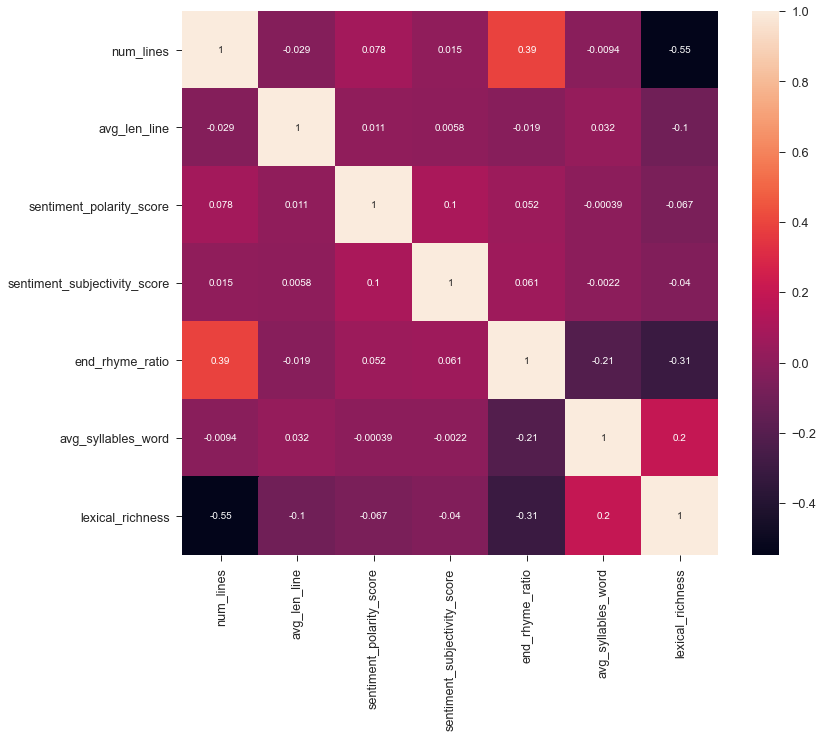

In [8]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

### Dealing with outliers

[[go back to the top](#Predicting-Poetic-Movements)]

- Cap or floor outlier values as necessary.

In [9]:
# make a copy for which I can rein in outlier values
df_capped = df.copy()

In [10]:
# find the outlier thresholds (using winsorization)
min_thresh = df[cont_cols].quantile(0.05)
max_thresh = df[cont_cols].quantile(0.95)
print(min_thresh)
print('-' * 42)
print(max_thresh)

num_lines                       7.000000
avg_len_line                    3.346818
sentiment_polarity_score       -0.970270
sentiment_subjectivity_score    0.257885
end_rhyme_ratio                 0.000000
avg_syllables_word              1.092393
lexical_richness                0.440678
Name: 0.05, dtype: float64
------------------------------------------
num_lines                       131.700000
avg_len_line                      9.750000
sentiment_polarity_score          0.995900
sentiment_subjectivity_score      0.687500
end_rhyme_ratio                   1.009091
avg_syllables_word                1.372212
lexical_richness                  0.850402
Name: 0.95, dtype: float64


#### Number of lines

In [11]:
# descriptive stats
df.num_lines.describe()

count    4307.000000
mean       40.269561
std        63.118049
min         1.000000
25%        14.000000
50%        22.000000
75%        40.000000
max       892.000000
Name: num_lines, dtype: float64

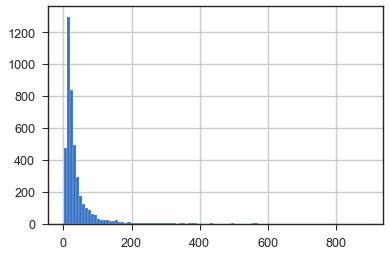

In [12]:
# current distribution
df.num_lines.hist(bins=100);

In [13]:
# cap/floor outliers
df_capped['num_lines'] = winsorizer(df['num_lines'])

# descriptive stats
df_capped['num_lines'].describe()

count    4307.000000
mean       34.295147
std        31.983861
min         7.000000
25%        14.000000
50%        22.000000
75%        40.000000
max       131.700000
Name: num_lines, dtype: float64

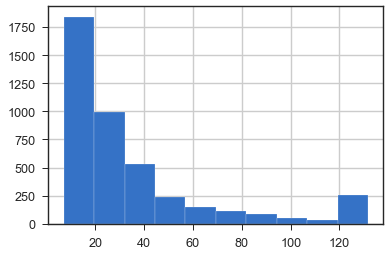

In [14]:
# new distribution
df_capped.num_lines.hist();

#### Average words per line

In [15]:
# descriptive stats
df.avg_len_line.describe()

count    4307.000000
mean        8.449181
std        37.933747
min         1.000000
25%         5.260870
50%         6.527778
75%         7.714286
max      1403.000000
Name: avg_len_line, dtype: float64

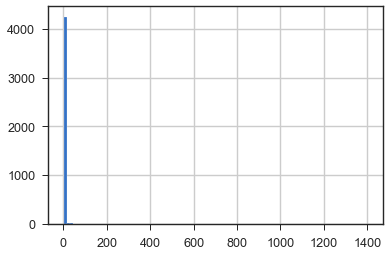

In [16]:
# current distribution
df.avg_len_line.hist(bins=100);

In [17]:
# cap/floor outliers
df_capped['avg_len_line'] = winsorizer(df['avg_len_line'])

# descriptive stats
df_capped['avg_len_line'].describe()

count    4307.000000
mean        6.494119
std         1.721049
min         3.346818
25%         5.260870
50%         6.527778
75%         7.714286
max         9.750000
Name: avg_len_line, dtype: float64

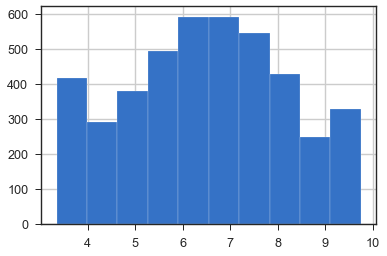

In [18]:
# new distribution
df_capped.avg_len_line.hist();

#### End rhyme ratio

In [19]:
# descriptive stats
df.end_rhyme_ratio.describe()

count    4307.000000
mean        0.302165
std         0.561589
min         0.000000
25%         0.000000
50%         0.127389
75%         0.416667
max        13.846154
Name: end_rhyme_ratio, dtype: float64

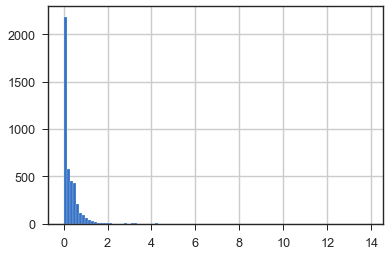

In [20]:
# current distribution
df.end_rhyme_ratio.hist(bins=100);

In [21]:
# cap/floor outliers
df_capped['end_rhyme_ratio'] = winsorizer(df['end_rhyme_ratio'])

# descriptive stats
df_capped['end_rhyme_ratio'].describe()

count    4307.000000
mean        0.254074
std         0.293332
min         0.000000
25%         0.000000
50%         0.127389
75%         0.416667
max         1.009091
Name: end_rhyme_ratio, dtype: float64

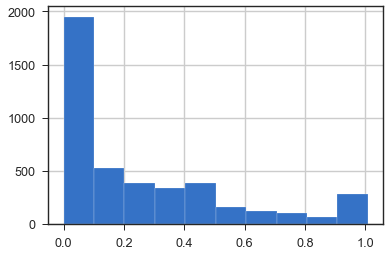

In [22]:
# new distribution
df_capped.end_rhyme_ratio.hist();

#### Average number of syllables per word

In [23]:
# descriptive stats
df.avg_syllables_word.describe()

count    4307.000000
mean        1.214609
std         0.087841
min         1.000000
25%         1.155752
50%         1.204545
75%         1.261905
max         1.771930
Name: avg_syllables_word, dtype: float64

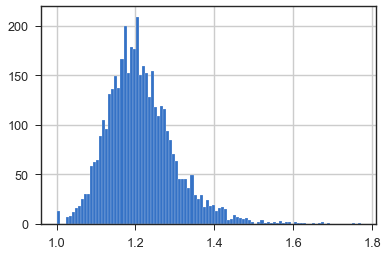

In [24]:
# current distribution
df.avg_syllables_word.hist(bins=100);

In [25]:
# cap/floor outliers
df_capped['avg_syllables_word'] = winsorizer(df['avg_syllables_word'])

# descriptive stats
df_capped['avg_syllables_word'].describe()

count    4307.000000
mean        1.212364
std         0.075228
min         1.092393
25%         1.155752
50%         1.204545
75%         1.261905
max         1.372212
Name: avg_syllables_word, dtype: float64

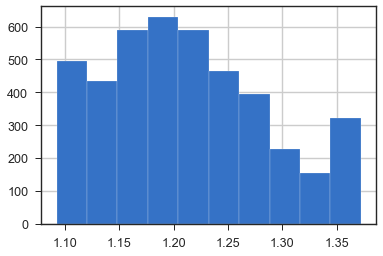

In [26]:
# new distribution
df_capped.avg_syllables_word.hist();

#### Lexical richness

In [27]:
# descriptive stats
df.lexical_richness.describe()

count    4307.000000
mean        0.657667
std         0.125099
min         0.066667
25%         0.580302
50%         0.666667
75%         0.740260
max         1.000000
Name: lexical_richness, dtype: float64

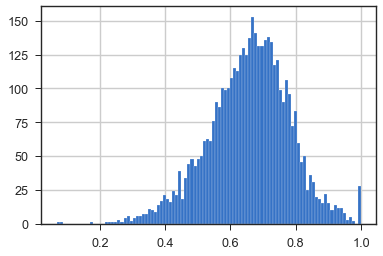

In [28]:
# current distribution
df.lexical_richness.hist(bins=100);

In [29]:
# cap/floor outliers
df_capped['lexical_richness'] = winsorizer(df['lexical_richness'])

# descriptive stats
df_capped['lexical_richness'].describe()

count    4307.000000
mean        0.658047
std         0.111326
min         0.440678
25%         0.580302
50%         0.666667
75%         0.740260
max         0.850402
Name: lexical_richness, dtype: float64

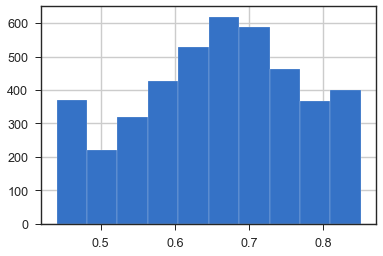

In [30]:
# new distribution
df_capped.lexical_richness.hist();

#### Subjectivity score

In [31]:
# descriptive stats
df.sentiment_subjectivity_score.describe()

count    4307.000000
mean        0.478008
std         0.135322
min         0.000000
25%         0.410284
50%         0.484470
75%         0.550000
max         1.000000
Name: sentiment_subjectivity_score, dtype: float64

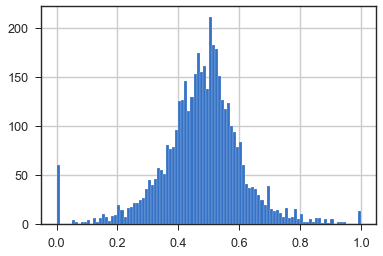

In [32]:
# current distribution
df.sentiment_subjectivity_score.hist(bins=100);

In [33]:
# cap/floor outliers
df_capped['sentiment_subjectivity_score'] = winsorizer(df['sentiment_subjectivity_score'])

# descriptive stats
df_capped['sentiment_subjectivity_score'].describe()

count    4307.000000
mean        0.479417
std         0.109112
min         0.257885
25%         0.410284
50%         0.484470
75%         0.550000
max         0.687500
Name: sentiment_subjectivity_score, dtype: float64

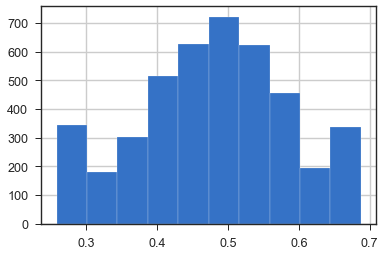

In [34]:
# new distribution
df_capped.sentiment_subjectivity_score.hist();

### 💾 Save/Load DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

In [35]:
# # uncomment to save
# with gzip.open('data/poetry_movements_df_capped.pkl', 'wb') as goodbye:
#     pickle.dump(df_capped, goodbye, protocol=pickle.HIGHEST_PROTOCOL)
    
# # uncomment to load
# with gzip.open('data/poetry_movements_df_capped.pkl', 'rb') as hello:
#     df_capped = pickle.load(hello)

### Train-test split

[[go back to the top](#Predicting-Poetic-Movements)]

- Create features DataFrame and target series. 
- Use 75% of the data as a training set and 25% as a testing set.
- Since I want to see if my engineered features improve my models beyond those using only word vectors, I'll also create separate vector-only training and testing sets.
    - Scale my engineered features.
    
#### Features and target

In [123]:
# create features dataframe
X = df_capped[
    ['num_lines', 'avg_len_line', 'sentiment_polarity_score', 
     'sentiment_subjectivity_score', 'end_rhyme_ratio', 
     'avg_syllables_word', 'lexical_richness', 
     'string_cleaned']
]

# assign target variable
y = df_capped['movement']

In [37]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

print(f'Train shape (rows, columns): {X_train.shape}')
print(f'Test shape (rows, columns): {X_test.shape}')

Train shape (rows, columns): (3230, 8)
Test shape (rows, columns): (1077, 8)


#### Scale numerical data

In [38]:
# separate out numerical data
X_train_nums = X_train.drop(columns='string_cleaned')
X_test_nums = X_test.drop(columns='string_cleaned')

In [39]:
# instantiate scaler
scaler = MinMaxScaler()

# scale numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

### Vectors DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

- Create a DataFrame of just word vectors (sparse), using TF-IDF Vectorizer.

In [40]:
%%time

# instantiate vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train.string_cleaned)
X_test_vec_matrix = vectorizer.transform(X_test.string_cleaned)

CPU times: user 466 ms, sys: 7.04 ms, total: 473 ms
Wall time: 472 ms


In [41]:
%%time

# convert tf-idf vectors into dataframe so I can better view feature importances
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, columns=vectorizer.get_feature_names())

CPU times: user 17 s, sys: 75.6 ms, total: 17 s
Wall time: 17.1 s


### Combo DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

- Combine vectors DataFrame with scaled numerical DataFrame.

In [42]:
# combine the numerical and vector dataframes for both train and test sets
X_train_combo = pd.concat([X_train_scaled_df, X_train_vec], axis=1)
X_test_combo = pd.concat([X_test_scaled_df, X_test_vec], axis=1)

# Step 2: Modeling

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll test out untuned Bernoulli Naive Bayes and Decision Tree models on both my vectors-only set and vectors-plus-features set.
- After an initial run through our basic models, I'll tune parameters.
- Finally, I can train and save a final model.


----------------------------

- Because the dataset is so large (in both rows and columns) and cross-validation is so intensive, we are only able to use train-test split to cross-validate.


## Baseline model

[[go back to the top](#Predicting-Poetic-Movements)]

- First, I'll try a model using only the TF-IDF vectors.
- Then I'll try a model using both my numerical features and the TF-IDF vectors.

### Vectors only

In [43]:
%%time

# instantiate the naive bayes classifier
benaba_vec = BernoulliNB()

# fit it to our training set
benaba_vec.fit(X_train_vec, y_train)

CPU times: user 4.02 s, sys: 479 ms, total: 4.5 s
Wall time: 4.15 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [44]:
%%time

# predict the new document from the testing dataset
y_train_preds_bnb_vec = benaba_vec.predict(X_train_vec)
y_test_preds_bnb_vec = benaba_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
benaba_vec_acc_train = accuracy_score(y_train, y_train_preds_bnb_vec)
benaba_vec_f1_train = f1_score(y_train, y_train_preds_bnb_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {benaba_vec_acc_train}')
print(f'F1 score: {benaba_vec_f1_train}')

# print out accuracy and f1 scores for test set
benaba_vec_acc_test = accuracy_score(y_test, y_test_preds_bnb_vec)
benaba_vec_f1_test = f1_score(y_test, y_test_preds_bnb_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {benaba_vec_acc_test}')
print(f'F1 score: {benaba_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_bnb_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_bnb_vec))

-----TRAIN-----
Accuracy: 0.6575851393188854
F1 score: 0.662223098170161

-----TEST-----
Accuracy: 0.4428969359331476
F1 score: 0.41395254927457104

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.62      0.12      0.20       239
 avant_garde       0.65      0.33      0.44       268
      modern       0.35      0.84      0.49       311
    pre_1900       0.70      0.38      0.49       259

    accuracy                           0.44      1077
   macro avg       0.58      0.42      0.41      1077
weighted avg       0.57      0.44      0.41      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 29  28 175   7]
 [ 14  88 158   8]
 [  4  18 261  28]
 [  0   2 158  99]]
CPU times: user 6.3 s, sys: 721 ms, total: 7.02 s
Wall time: 5.74 s


- Not too bad for a baseline. Certainly better than just predicting 'modern', which would give you a 29% accuracy.
- That said, it is indeed overpredicting on 'modern'.
- It appears to be having the most trouble with Metropolitan poetry.

#### Feature importances

In [45]:
# function to print top 10 features for each class
print_nb_features(
            benaba_vec,
            X_train_vec,
            ['metropolitan', 'avant_garde', 'modern', 'pre_1900']
        )

Metropolitan tweets:
aalto, nibbed, nib, niagara, nhat, nguin, ngorongoro, nglish, nghe, nez

Avant-Garde tweets:
zwim, scaut, scaur, gullied, scauld, scaul, scaud, scatterd, scathing, scath

Modern tweets:
aalto, morituri, morison, moribund, moriartys, moreton, moren, morello, mordecai, mormorio

Pre-1900 tweets:
aalto, halidom, halios, santo, hallelujah, santit, hallmark, halloing, santa, hallooed



- An interesting mix of words, many of which appear to be typos or perhaps part of a hyphenated word that ran onto a different line.

#### Confusion matrix

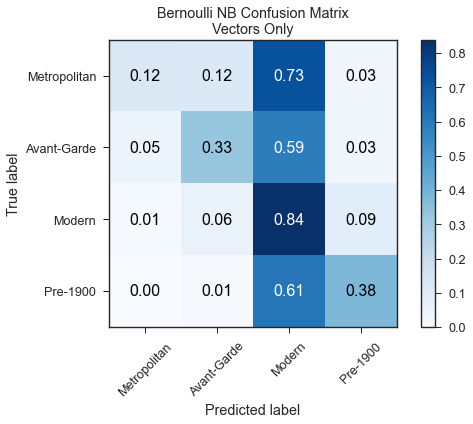

In [46]:
# plot confusion matrix - normalized
cm_benaba = confusion_matrix(y_test, y_test_preds_bnb_vec)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(cm_benaba, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix\nVectors Only', cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/bnb_vec_cm.png', transparent=True, bbox_inches='tight', dpi=100)

### Vectors + numerical data

In [47]:
%%time

# instantiate the naive bayes classifier
benaba_combo = BernoulliNB()

# fit it to our training set
benaba_combo.fit(X_train_combo, y_train)

CPU times: user 8.54 s, sys: 1.54 s, total: 10.1 s
Wall time: 9.84 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [48]:
%%time

# predict the new document from the testing dataset
y_train_preds_bnb_combo = benaba_combo.predict(X_train_combo)
y_test_preds_bnb_combo = benaba_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
benaba_combo_acc_train = accuracy_score(y_train, y_train_preds_bnb_combo)
benaba_combo_f1_train = f1_score(y_train, y_train_preds_bnb_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {benaba_combo_acc_train}')
print(f'F1 score: {benaba_combo_f1_train}')

# print out accuracy and f1 scores for test set
benaba_combo_acc_test = accuracy_score(y_test, y_test_preds_bnb_combo)
benaba_combo_f1_test = f1_score(y_test, y_test_preds_bnb_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {benaba_combo_acc_test}')
print(f'F1 score: {benaba_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_bnb_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_bnb_combo))

-----TRAIN-----
Accuracy: 0.6643962848297214
F1 score: 0.6685623743394035

-----TEST-----
Accuracy: 0.4503249767873723
F1 score: 0.4264836594564233

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.65      0.15      0.25       239
 avant_garde       0.65      0.33      0.44       268
      modern       0.35      0.84      0.49       311
    pre_1900       0.70      0.38      0.49       259

    accuracy                           0.45      1077
   macro avg       0.59      0.43      0.42      1077
weighted avg       0.58      0.45      0.43      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 37  28 167   7]
 [ 15  89 157   7]
 [  5  18 260  28]
 [  0   2 158  99]]
CPU times: user 12.2 s, sys: 2.15 s, total: 14.4 s
Wall time: 13.2 s


- Practically the same result; a very slight boost if anything.

#### Confusion matrix

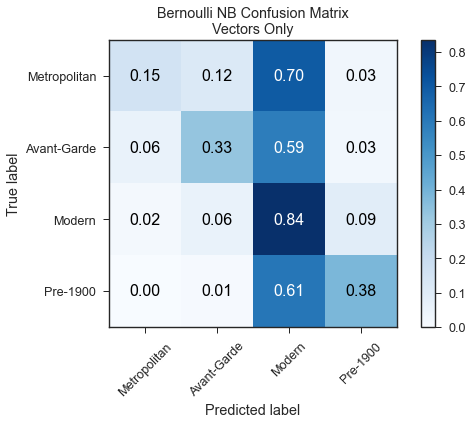

In [49]:
# plot confusion matrix - normalized
cm = confusion_matrix(y_test, y_test_preds_bnb_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(cm, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix\nVectors Only', cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/bnb_combo_cm.png', transparent=True, bbox_inches='tight', dpi=100)

- This confirms it is practically the same, with a slightly better accuracy at predicting Metropolitan.

#### Feature importances

In [50]:
# function to print top 10 features for each class
print_nb_features(
            benaba_combo,
            X_train_combo,
            ['metropolitan', 'avant_garde', 'modern', 'pre_1900']
        )

Metropolitan tweets:
leeward, niagara, nhat, nguin, ngorongoro, nglish, nghe, nez, nex, newtown

Avant-Garde tweets:
leeward, monian, monhegan, mongst, mongrel, mongoose, mongolian, mong, mondo, monde

Modern tweets:
leeward, morison, moribund, moriartys, moreton, moren, morello, mordecai, moralistic, morituri

Pre-1900 tweets:
grincait, irving, irritation, irritable, irrigation, irrigate, irrevocable, irreversibl, irretrievably, irretrievables



- Interestingly, these are still all word vectors, but different from the vectors-only model.

## K-Nearest Neighbors

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

In [51]:
%%time

# instantiate decision tree classifiers
knn_vec = KNeighborsClassifier()
knn_combo = KNeighborsClassifier()

# fit them to the training set and evaluate
cv_scores_knn_vec = cross_val_score(
    knn_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_knn_combo = cross_val_score(
    knn_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_knn_vec}')
print(f'Average score: {np.mean(cv_scores_knn_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_knn_combo}')
print(f'Average score: {np.mean(cv_scores_knn_combo)}\n')

-----Vectors only-----
All scores: [0.45549181 0.48010828 0.40762273 0.52430862 0.41714101 0.46658148
 0.40206746 0.44194881 0.49727948 0.41709663]
Average score: 0.4509646304969624

------Vectors + Numerical Data-----
All scores: [0.54448047 0.51639483 0.52337022 0.56402105 0.53402214 0.53691744
 0.51938092 0.52058681 0.52834179 0.52834396]
Average score: 0.5315859631347133

CPU times: user 3min 39s, sys: 6.59 s, total: 3min 46s
Wall time: 9min 32s


- This performs better than the Naive Bayes model, and the combo data set is far better than vectors only.
- First, I'll try to find the best value for *k*, then train a model.

### Vectors + numerical data

100%|██████████| 25/25 [27:31<00:00, 66.04s/it]


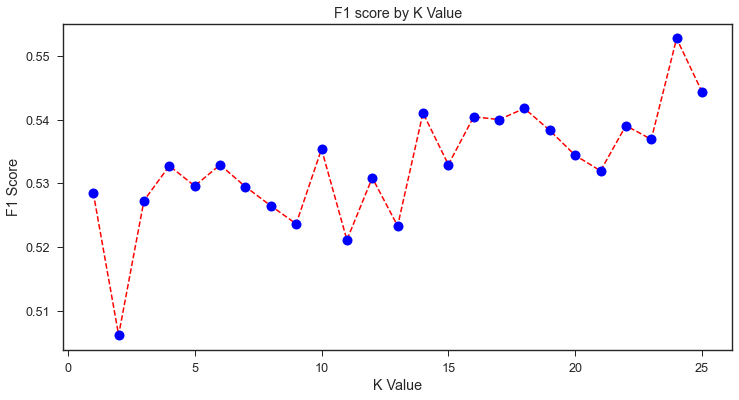

CPU times: user 2h 22min 26s, sys: 1min 32s, total: 2h 23min 58s
Wall time: 27min 31s


In [53]:
%%time

# create a container to track the scores
k_scores = []

# set up a loop to fit the model using a different values of k
k_range = list(range(1, 26))
for k in tqdm(k_range):
    
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    # fit the model and get the score on an evaluation metric
    knn.fit(X_train_combo, y_train)
    y_pred = knn.predict(X_test_combo)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # add to container
    k_scores.append(f1)
    
# plot a graph
plt.figure(figsize=(12, 6))  
plt.plot(k_range, k_scores, color='red', linestyle='dashed', 
         marker='o', markerfacecolor='blue', markersize=10)
plt.title('F1 score by K Value')  
plt.xlabel('K Value')  
plt.ylabel('F1 Score') 
plt.show()

In [65]:
# five highest scores
sorted_scores = sorted(list(enumerate(k_scores, 1)), 
                       key=lambda tup: tup[1], 
                       reverse=True)
sorted_scores[:5]

[(24, 0.5527301128264127),
 (25, 0.5443611441514613),
 (18, 0.5417521422544705),
 (14, 0.5410371366292553),
 (16, 0.5404437241623725)]

- *k=24* appears to have the best results, so I'll train a model on that.

In [68]:
%%time

# instantiate the model
knn_combo = KNeighborsClassifier(
    n_neighbors=24, 
    p=2, 
    n_jobs=-1)

# fit to the training set
knn_combo.fit(X_train_combo, y_train)

CPU times: user 12.9 s, sys: 1.81 s, total: 14.7 s
Wall time: 14.9 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=24, p=2,
                     weights='uniform')

In [69]:
%%time

# predict class for the train and test sets
y_train_preds_knn_combo = knn_combo.predict(X_train_combo)
y_test_preds_knn_combo = knn_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
knn_combo_acc_train = accuracy_score(y_train, y_train_preds_knn_combo)
knn_combo_f1_train = f1_score(y_train, y_train_preds_knn_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {knn_combo_acc_train}')
print(f'F1 score: {knn_combo_f1_train}')

# print out accuracy and f1 scores for test set
knn_combo_acc_test = accuracy_score(y_test, y_test_preds_knn_combo)
knn_combo_f1_test = f1_score(y_test, y_test_preds_knn_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {knn_combo_acc_test}')
print(f'F1 score: {knn_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_knn_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_knn_combo))

-----TRAIN-----
Accuracy: 0.595046439628483
F1 score: 0.5891827210046805

-----TEST-----
Accuracy: 0.5598885793871866
F1 score: 0.5527301128264127

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.54      0.62      0.58       239
 avant_garde       0.55      0.48      0.51       268
      modern       0.48      0.40      0.44       311
    pre_1900       0.66      0.78      0.71       259

    accuracy                           0.56      1077
   macro avg       0.56      0.57      0.56      1077
weighted avg       0.55      0.56      0.55      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[149  43  40   7]
 [ 69 128  53  18]
 [ 55  53 125  78]
 [  5  10  43 201]]
CPU times: user 22min 2s, sys: 7.92 s, total: 22min 10s
Wall time: 3min 21s


#### Confusion matrix

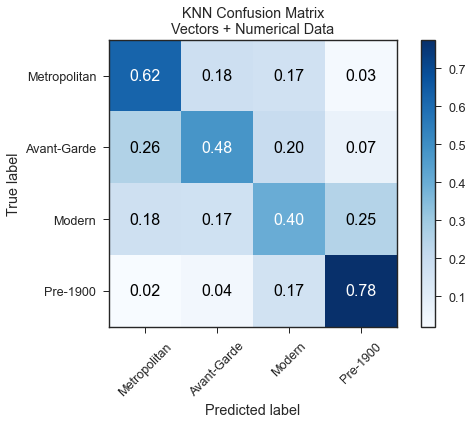

In [70]:
# plot confusion matrix - normalized
cm = confusion_matrix(y_test, y_test_preds_knn_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(cm, classes, normalize=True,
                      title='KNN Confusion Matrix\nVectors + Numerical Data', cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/knn_combo_cm.png', transparent=True, bbox_inches='tight', dpi=100)

- This is definitely better than the Naive Bayes model.
    - It predicts Modern a lot less. If anything, it has perhaps gone too far in the other direction.
    - Much better at predicting Metropolitan, which is interesting. Perhaps this genre is quite clustered.
    - Predictions seem fairly evenly spread.
    - Has trouble correctly predicting Modern and Avant-Garde.
    
- Very decent fit.

## Decision Tree

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

⏰ NOTE: This will take a few minutes to run.

In [77]:
%%time

# instantiate decision tree classifiers
tree_vec = DecisionTreeClassifier()
tree_combo = DecisionTreeClassifier()

# fit them to the training set and evaluate
cv_scores_tree_vec = cross_val_score(
    tree_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_tree_combo = cross_val_score(
    tree_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_tree_vec}')
print(f'Average score: {np.mean(cv_scores_tree_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_tree_combo}')
print(f'Average score: {np.mean(cv_scores_tree_combo)}\n')

-----Vectors only-----
All scores: [0.38359247 0.35297356 0.42890261 0.35097098 0.41296087 0.36372053
 0.3736484  0.39082299 0.43215202 0.39187787]
Average score: 0.38816222948811513

------Vectors + Numerical Data-----
All scores: [0.42174012 0.4520343  0.4456421  0.45588187 0.44062612 0.45471727
 0.45237006 0.48405022 0.48016292 0.44312837]
Average score: 0.45303533500125387

CPU times: user 3min 11s, sys: 3.83 s, total: 3min 14s
Wall time: 4min 34s


- Decision Tree isn't shaping up to be a very good model; it is not much better than Naive Bayes and definitely worse than KNN.
- I'll keep it in mind if I need to check out feature importances, since KNN doesn't provide that information. I should be able to obtain that using Random Forest, however.

## Random Forest

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors-only model and a combo model.

⏰ NOTE: This will take a several minutes to run.

In [78]:
%%time

# instantiate random forest classifiers
forest_vec = RandomForestClassifier()
forest_combo = RandomForestClassifier()

# fit them to the training set and evaluate
cv_scores_forest_vec = cross_val_score(
    forest_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_forest_combo = cross_val_score(
    forest_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_forest_vec}')
print(f'Average score: {np.mean(cv_scores_forest_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_forest_combo}')
print(f'Average score: {np.mean(cv_scores_forest_combo)}\n')

-----Vectors only-----
All scores: [0.47514723 0.54638671 0.56385809 0.50452191 0.54407828 0.4959448
 0.560656   0.55227651 0.56550335 0.50667619]
Average score: 0.5315049068830067

------Vectors + Numerical Data-----
All scores: [0.56556445 0.63353632 0.62086629 0.61754142 0.60583686 0.56756118
 0.56293599 0.59400505 0.57688534 0.53908963]
Average score: 0.5883822530846099

CPU times: user 3min 16s, sys: 3.26 s, total: 3min 20s
Wall time: 4min 59s


- Including engineered features seems more promising, so I'll move ahead with this one.

### Vectors + numerical data

In [79]:
%%time

# instantiate the model
forest_combo = RandomForestClassifier(random_state=1)

# fit to the training set
forest_combo.fit(X_train_combo, y_train)

CPU times: user 19.3 s, sys: 1.21 s, total: 20.5 s
Wall time: 20.6 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [80]:
%%time

# predict class for the train and test sets
y_train_preds_forest_combo = forest_combo.predict(X_train_combo)
y_test_preds_forest_combo = forest_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
forest_combo_acc_train = accuracy_score(y_train, y_train_preds_forest_combo)
forest_combo_f1_train = f1_score(y_train, y_train_preds_forest_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {forest_combo_acc_train}')
print(f'F1 score: {forest_combo_f1_train}')

# print out accuracy and f1 scores for test set
forest_combo_acc_test = accuracy_score(y_test, y_test_preds_forest_combo)
forest_combo_f1_test = f1_score(y_test, y_test_preds_forest_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {forest_combo_acc_test}')
print(f'F1 score: {forest_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_forest_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_forest_combo))

-----TRAIN-----
Accuracy: 1.0
F1 score: 1.0

-----TEST-----
Accuracy: 0.6016713091922006
F1 score: 0.5986261093847224

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.62      0.48      0.54       239
 avant_garde       0.57      0.46      0.51       268
      modern       0.50      0.66      0.57       311
    pre_1900       0.76      0.79      0.78       259

    accuracy                           0.60      1077
   macro avg       0.61      0.60      0.60      1077
weighted avg       0.61      0.60      0.60      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[114  54  64   7]
 [ 41 124  90  13]
 [ 29  33 206  43]
 [  0   6  49 204]]
CPU times: user 7.4 s, sys: 1.52 s, total: 8.93 s
Wall time: 8.96 s


#### Confusion matrix

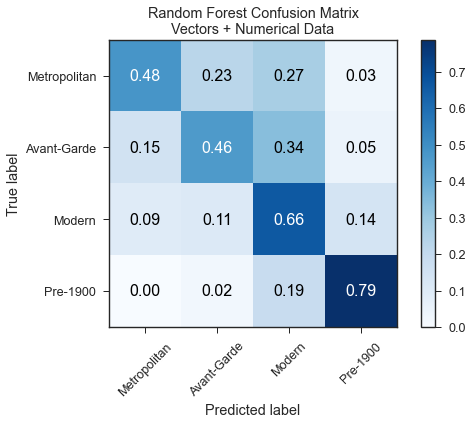

In [81]:
# plot confusion matrix - normalized
cm = confusion_matrix(y_test, y_test_preds_forest_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(
    cm, 
    classes, 
    normalize=True,
    title='Random Forest Confusion Matrix\nVectors + Numerical Data', 
    cmap=plt.cm.Blues)

# uncomment to save
plt.savefig('charts/rf_combo_cm.png', transparent=True, 
            bbox_inches='tight', dpi=100)

- Much better overall F1 score, but I'm back to overpredicting Modern.
- Unlike KNN, however, this is very overfit, so tuning this would definitely be necessary.
- Still, this will be a great model to use to look at important features.

#### Feature importances

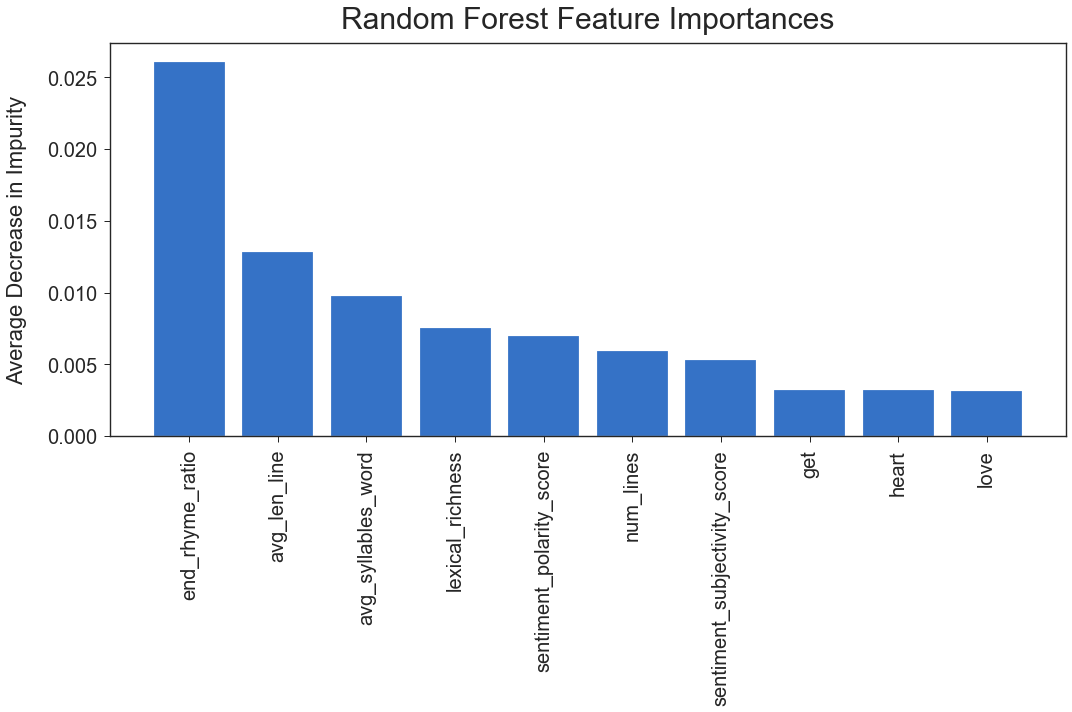





[('end_rhyme_ratio', 0.026054299856886214), ('avg_len_line', 0.012832222194416591), ('avg_syllables_word', 0.009750120271243508), ('lexical_richness', 0.007506823843911164), ('sentiment_polarity_score', 0.006956846654455948), ('num_lines', 0.00594112815701216), ('sentiment_subjectivity_score', 0.0052842133284028816), ('get', 0.003217866761298479), ('heart', 0.0032125895701922086), ('love', 0.0031625975579694324)]


In [82]:
# top 10 features
plot_forest_features(
    forest_combo, 
    X_train_combo)

- Mostly engineered features here, with the ratio of end rhymes to total lines have a large importance compared to the rest.
- Also, some interesting words.
    - *Get* only appears in the top 25 words for Metropolitan poetry.
    - *Heart* only appears in the top 25 words for Pre-1900 poetry.
    - *Love* is the second most used word (after processing), and appears in the top 25 of all classes.

## SVM

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first take a look at cross validation scores for a vectors only model and a combo model.

⏰ NOTE: Next cell took me 5 minutes to run.

In [85]:
%%time

# instantiate svm classifiers
svm_vec = LinearSVC()
svm_combo = LinearSVC()

# fit them to the training set and evaluate
cv_scores_svm_vec = cross_val_score(
    svm_vec, X_train_vec, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_svm_combo = cross_val_score(
    svm_combo, X_train_combo, y_train, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_svm_vec}')
print(f'Average score: {np.mean(cv_scores_svm_vec)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_svm_combo}')
print(f'Average score: {np.mean(cv_scores_svm_combo)}\n')

-----Vectors only-----
All scores: [0.59927349 0.62445846 0.58584666 0.58607154 0.59590419 0.62376079
 0.59672248 0.62379556 0.61900537 0.55320236]
Average score: 0.6008040890752009

------Vectors + Numerical Data-----
All scores: [0.6295326  0.65485259 0.6320959  0.62857459 0.61674317 0.64645281
 0.6328984  0.64292339 0.66444116 0.60339052]
Average score: 0.6351905127838536

CPU times: user 3min 21s, sys: 5.62 s, total: 3min 27s
Wall time: 5min 30s


- This is the best one yet! And I'm not surprised. SVM tends to work well with text classification and data that has fewer data points and lots of variables (i.e. word vectors).
- Once again, my engineered features seem to help out the model, so I'll train a basic one here, then I can focus on tuning parameters.

### Vectors + numerical data

In [98]:
%%time

# instantiate the model
svm_combo = LinearSVC(random_state=1)

# fit to the training set
svm_combo.fit(X_train_combo, y_train)

CPU times: user 24.8 s, sys: 1.53 s, total: 26.4 s
Wall time: 26.4 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [99]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo = svm_combo.predict(X_train_combo)
y_test_preds_svm_combo = svm_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train = accuracy_score(y_train, y_train_preds_svm_combo)
svm_combo_f1_train = f1_score(y_train, y_train_preds_svm_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train}')
print(f'F1 score: {svm_combo_f1_train}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test = accuracy_score(y_test, y_test_preds_svm_combo)
svm_combo_f1_test = f1_score(y_test, y_test_preds_svm_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test}')
print(f'F1 score: {svm_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo))

-----TRAIN-----
Accuracy: 0.9993808049535604
F1 score: 0.9993807503966002

-----TEST-----
Accuracy: 0.6555246053853296
F1 score: 0.6511720162487891

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.60      0.65      0.62       239
 avant_garde       0.63      0.56      0.59       268
      modern       0.60      0.56      0.58       311
    pre_1900       0.78      0.88      0.83       259

    accuracy                           0.66      1077
   macro avg       0.65      0.66      0.65      1077
weighted avg       0.65      0.66      0.65      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[155  35  40   9]
 [ 52 149  57  10]
 [ 48  43 173  47]
 [  3   8  19 229]]
CPU times: user 8.38 s, sys: 1.78 s, total: 10.2 s
Wall time: 9.19 s


#### Confusion matrix

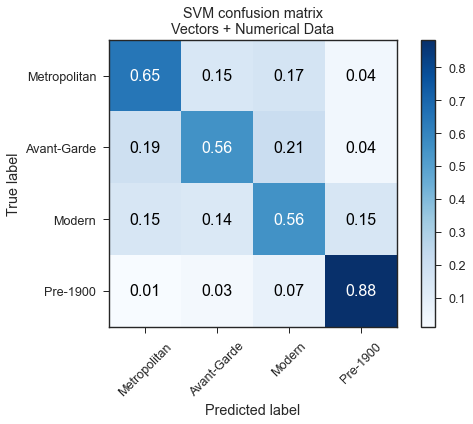

In [100]:
# confusion matrix with sklearn
cm = confusion_matrix(y_test, y_test_preds_svm_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

# plot as graph
plot_confusion_matrix(
    cm, 
    classes,
    normalize=True,
    title='SVM confusion matrix\nVectors + Numerical Data',
    cmap=plt.cm.Blues);

- Still overfit but a very good spread of predictions here compared to the other models.
    - Each category is correctly predicted at least half the time.
- Pre-1900 poetry is very easily recognized by the model.
    - Modern poetry appears to be the largest confusing factor here, so must share some similarities. 
    - Avant-Garde and Metropolitan are hardly ever predicted for Pre-1900 poems and Pre-1900 is hardly predicted for Metropolitan and Avant-Garde poems.
- As in the KNN, Metropolitan has seen quite a boost, whereas Avant-Garde and Modern seem a little more difficult to correctly predict.

#### Feature importances

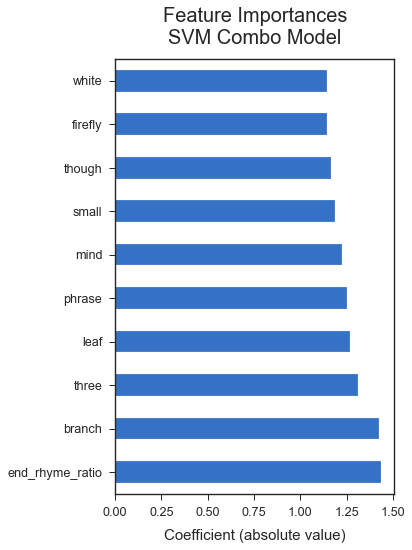

In [101]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo.coef_[0]), 
              index=X_train_combo.columns).nlargest(10).\
              plot(kind='barh');

- Only the ratio of end rhymes to total lines made it from my engineered features. 
- Mostly surprising words, *white* being the only word in the top 25 overall.

## Parameter tuning

[[go back to the top](#Predicting-Poetic-Movements)]

#### Changing C value and class weight

⏰ NOTE: Next cell took me 10 minutes to run.

In [110]:
param_grid = {
#     'penalty': ['l1', 'l2'],
#     'loss': ['hinge', 'squared_hinge'],
    'C': [0.5, 0.9, 1, 1.5, 2, 3]
}

In [91]:
from sklearn.model_selection import GridSearchCV

In [111]:
svm_grid = GridSearchCV(LinearSVC(random_state=1), param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=2)

In [112]:
svm_grid.fit(X_train_combo, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=1, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.5, 0.9, 1, 1.5, 2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_weighted', verbose=2)

In [113]:
# examine the best model
print(svm_grid.best_score_)
print(svm_grid.best_params_)
print(svm_grid.best_estimator_)

0.6437159494887166
{'C': 0.5}
LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)


In [114]:
%%time

# instantiate the model
svm_combo2 = LinearSVC(C=0.5, random_state=1)

# fit to the training set
svm_combo2.fit(X_train_combo, y_train)

CPU times: user 27.6 s, sys: 1.71 s, total: 29.3 s
Wall time: 29.5 s


LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
          verbose=0)

In [115]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo2 = svm_combo2.predict(X_train_combo)
y_test_preds_svm_combo2 = svm_combo2.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train2 = accuracy_score(y_train, y_train_preds_svm_combo2)
svm_combo_f1_train2 = f1_score(y_train, y_train_preds_svm_combo2, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train2}')
print(f'F1 score: {svm_combo_f1_train2}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test2 = accuracy_score(y_test, y_test_preds_svm_combo2)
svm_combo_f1_test2 = f1_score(y_test, y_test_preds_svm_combo2, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test2}')
print(f'F1 score: {svm_combo_f1_test2}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo2, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo2))

-----TRAIN-----
Accuracy: 0.993188854489164
F1 score: 0.9931863885861856

-----TEST-----
Accuracy: 0.6527390900649953
F1 score: 0.6476689237523853

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.59      0.65      0.62       239
 avant_garde       0.62      0.54      0.58       268
      modern       0.60      0.54      0.57       311
    pre_1900       0.78      0.90      0.83       259

    accuracy                           0.65      1077
   macro avg       0.65      0.66      0.65      1077
weighted avg       0.65      0.65      0.65      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[156  34  39  10]
 [ 56 146  56  10]
 [ 50  47 169  45]
 [  3   8  16 232]]
CPU times: user 8.44 s, sys: 1.8 s, total: 10.2 s
Wall time: 9.28 s


#### Confusion matrix

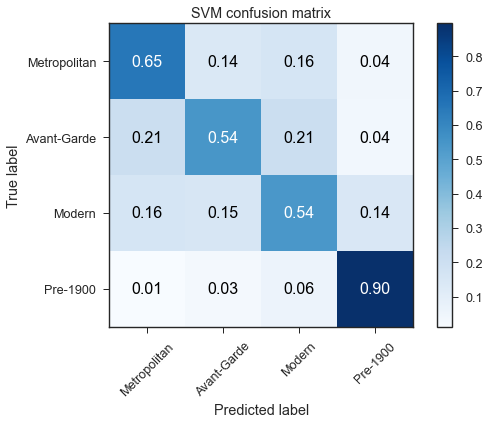

In [116]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo2)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

#### Feature importances

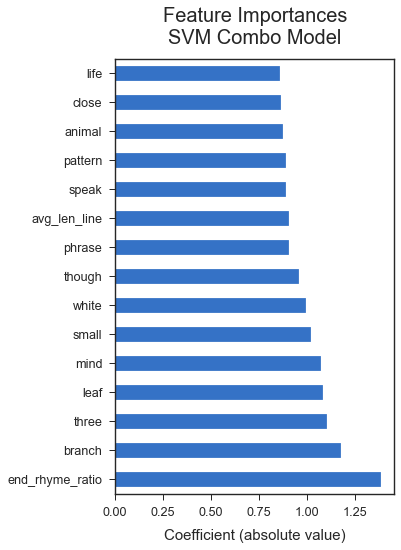

In [120]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo2.coef_[0]), index=X_train_combo.columns).nlargest(15).plot(kind='barh');

In [83]:
from sklearn.svm import LinearSVC

In [78]:
%%time

# instantiate the model
svm_lin_combo = LinearSVC(
#     C=2, 
#     class_weight='balanced'
)

# fit to the training set
svm_lin_combo.fit(X_train_combo, y_train)

CPU times: user 24.7 s, sys: 1.57 s, total: 26.2 s
Wall time: 26.3 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [79]:
%%time

# predict class for the train and test sets
y_train_preds_svm_lin_combo = svm_lin_combo.predict(X_train_combo)
y_test_preds_svm_lin_combo = svm_lin_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_lin_combo_acc_train = accuracy_score(y_train, y_train_preds_svm_lin_combo)
svm_lin_combo_f1_train = f1_score(y_train, y_train_preds_svm_lin_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_lin_combo_acc_train}')
print(f'F1 score: {svm_lin_combo_f1_train}')

# print out accuracy and f1 scores for test set
svm_lin_combo_acc_test = accuracy_score(y_test, y_test_preds_svm_lin_combo)
svm_lin_combo_f1_test = f1_score(y_test, y_test_preds_svm_lin_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_lin_combo_acc_test}')
print(f'F1 score: {svm_lin_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_lin_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_lin_combo))

-----TRAIN-----
Accuracy: 0.9996904024767802
F1 score: 0.9996903889420556

-----TEST-----
Accuracy: 0.6239554317548747
F1 score: 0.620327641509353

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.56      0.51      0.53       239
 avant_garde       0.57      0.56      0.56       268
      modern       0.56      0.55      0.56       311
    pre_1900       0.79      0.88      0.83       259

    accuracy                           0.62      1077
   macro avg       0.62      0.63      0.62      1077
weighted avg       0.62      0.62      0.62      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[123  54  52  10]
 [ 43 150  63  12]
 [ 51  51 172  37]
 [  4   8  20 227]]
CPU times: user 8.48 s, sys: 1.83 s, total: 10.3 s
Wall time: 9.33 s


#### Confusion matrix

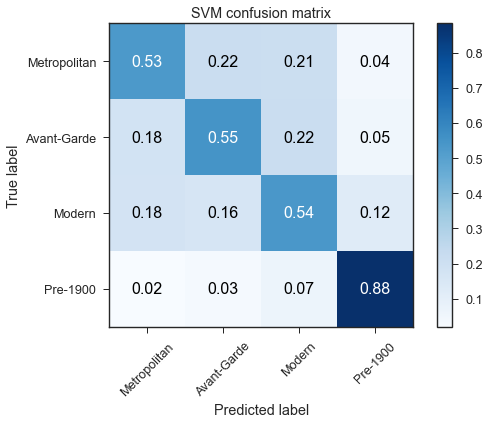

In [77]:
cm = confusion_matrix(y_test, y_test_preds_svm_lin_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']

plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

In [121]:
df_capped.columns

Index(['poet', 'poem_url', 'title', 'poem_lines', 'poem_string', 'genre',
       'movement', 'clean_lines', 'num_lines', 'lines_titled', 'num_words',
       'avg_len_line', 'string_titled', 'sentiment_polarity_score',
       'sentiment_polarity', 'sentiment_subjectivity_score', 'num_end_rhymes',
       'end_rhyme_ratio', 'end_rhyme', 'avg_syllables_word',
       'lexical_richness', 'string_cleaned'],
      dtype='object')

In [151]:
# create features dataframe
X2 = df_capped[
    ['num_lines', 'avg_len_line', 'sentiment_polarity_score', 
     'sentiment_subjectivity_score', 'end_rhyme_ratio', 
     'avg_syllables_word', 'lexical_richness', 
     'string_titled']
]

# assign target variable
y2 = df_capped['movement']

In [152]:
X2['string_titled'] = X2.string_titled.apply(simple_process)
X2.loc[0, 'string_titled']

'a supermarket in california what thoughts i have of you tonight walt whitman for i walked down the sidestreets under the trees with a headache self conscious looking at the full moon in my hungry fatigue and shopping for images i went into the neon fruit supermarket dreaming of your enumerations what peaches and what penumbras whole families shopping at night aisles full of husbands wives in the avocados babies in the tomatoes and you garcia lorca what were you doing down by the watermelons i saw you walt whitman childless lonely old grubber poking among the meats in the refrigerator and eyeing the grocery boys i heard you asking questions of each who killed the pork chops what price bananas are you my angel i wandered in and out of the brilliant stacks of cans following you and followed in my imagination by the store detective we strode down the open corridors together in our solitary fancy tasting artichokes possessing every frozen delicacy and never passing the cashier where are we

In [153]:
# train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=y2, random_state=42)

print(f'Train shape (rows, columns): {X_train2.shape}')
print(f'Test shape (rows, columns): {X_test2.shape}')

Train shape (rows, columns): (3230, 8)
Test shape (rows, columns): (1077, 8)


#### Scale numerical data

In [38]:
# # separate out numerical data
# X_train_nums = X_train.drop(columns='string_titled')
# X_test_nums = X_test.drop(columns='string_titled')

In [39]:
# # instantiate scaler
# scaler = MinMaxScaler()

# # scale numerical data
# X_train_scaled = scaler.fit_transform(X_train_nums)
# X_test_scaled = scaler.transform(X_test_nums)

# # turn the arrays into dataframes
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

### Vectors DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

- Create a DataFrame of just word vectors (sparse), using TF-IDF Vectorizer.

In [154]:
%%time

# instantiate vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix2 = vectorizer.fit_transform(X_train2.string_titled)
X_test_vec_matrix2 = vectorizer.transform(X_test2.string_titled)

CPU times: user 864 ms, sys: 44.5 ms, total: 908 ms
Wall time: 937 ms


In [155]:
%%time

# convert tf-idf vectors into dataframe so I can better view feature importances
X_train_vec2 = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix2, columns=vectorizer.get_feature_names())
X_test_vec2 = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix2, columns=vectorizer.get_feature_names())

CPU times: user 23 s, sys: 745 ms, total: 23.8 s
Wall time: 23.9 s


### Combo DataFrame

[[go back to the top](#Predicting-Poetic-Movements)]

- Combine vectors DataFrame with scaled numerical DataFrame.

In [156]:
# combine the numerical and vector dataframes for both train and test sets
X_train_combo2 = pd.concat([X_train_scaled_df, X_train_vec2], axis=1)
X_test_combo2 = pd.concat([X_test_scaled_df, X_test_vec2], axis=1)

In [157]:
X_train_combo2.shape

(3230, 43053)

In [144]:
# apply text cleaning techniques
def simple_process(text):
    
    '''
    Function to make text lowercase, tokenize words and words with 
    apostrophes, convert contractions to full words, lemmatize by 
    POS tag, and remove stop words and words shorter than 3 
    characters.
    
    Input
    -----
    text : str
        Text to be cleaned.
    stop_words : list (str)
        List of words to remove from the text.
        
    Output
    ------
    text : str
        Lowercase, lemmatized text without contractions, stop words,
        and one- to two-letter words.
    '''
    
    # make text lowercase and convert some punctuation
    text = text.lower().replace("’", "'").replace('—', ' ').\
                replace('-', ' ')
    
    # remove punctuation other than apostrophes
    text = text.translate(str.maketrans(
        '', '', string.punctuation.replace("'", "")))

    # initial tokenization to remove non-words
    tokenizer = RegexpTokenizer("([a-z]+(?:'[a-z]+)?)")
    words = tokenizer.tokenize(text)

    # convert contractions
    contractions = load_dict_contractions()
    words = [contractions[word] if word in contractions else \
             word for word in words]
    
    # stringify and remove leftover apostrophes
    text = ' '.join(words)
    text = text.replace("'", "")
    
    return text

In [161]:
%%time

# instantiate random forest classifiers
svm_lin_vec2 = LinearSVC()
svm_lin_combo2 = LinearSVC()

# fit them to the training set and evaluate
cv_scores_svm_lin_vec2 = cross_val_score(
    svm_lin_vec2, X_train_vec2, y_train2, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

cv_scores_svm_lin_combo2 = cross_val_score(
    svm_lin_combo2, X_train_combo2, y_train2, 
    scoring='f1_weighted', cv=10, n_jobs=-1
)

# create printout
print('-----Vectors only-----')
print(f'All scores: {cv_scores_svm_lin_vec2}')
print(f'Average score: {np.mean(cv_scores_svm_lin_vec2)}\n')
print('------Vectors + Numerical Data-----')
print(f'All scores: {cv_scores_svm_lin_combo2}')
print(f'Average score: {np.mean(cv_scores_svm_lin_combo2)}\n')

-----Vectors only-----
All scores: [0.62761568 0.71386136 0.59946969 0.64340131 0.65450934 0.66156892
 0.58829792 0.61299607 0.65410261 0.60955467]
Average score: 0.636537757851741

------Vectors + Numerical Data-----
All scores: [0.65097901 0.70820609 0.64683284 0.68607899 0.65457732 0.67129181
 0.66054012 0.67212663 0.72090737 0.63698163]
Average score: 0.6708521793164735

CPU times: user 4min 35s, sys: 10.4 s, total: 4min 46s
Wall time: 7min 34s


## Baseline model

[[go back to the top](#Predicting-Poetic-Movements)]

- First, I'll try a model using only the TF-IDF vectors.
- Then I'll try a model using both my numerical features and the TF-IDF vectors.

### Vectors only

In [162]:
%%time

# instantiate the naive bayes classifier
benaba_vec = BernoulliNB()

# fit it to our training set
benaba_vec.fit(X_train_vec2, y_train2)

CPU times: user 5.76 s, sys: 878 ms, total: 6.64 s
Wall time: 6.19 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [167]:
%%time

# predict the new document from the testing dataset
y_train_preds_bnb_vec = benaba_vec.predict(X_train_vec2)
y_test_preds_bnb_vec = benaba_vec.predict(X_test_vec2)

# print out accuracy and f1 scores for train set
benaba_vec_acc_train = accuracy_score(y_train2, y_train_preds_bnb_vec)
benaba_vec_f1_train = f1_score(y_train2, y_train_preds_bnb_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {benaba_vec_acc_train}')
print(f'F1 score: {benaba_vec_f1_train}')

# print out accuracy and f1 scores for test set
benaba_vec_acc_test = accuracy_score(y_test2, y_test_preds_bnb_vec)
benaba_vec_f1_test = f1_score(y_test2, y_test_preds_bnb_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {benaba_vec_acc_test}')
print(f'F1 score: {benaba_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test2, y_test_preds_bnb_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test2, y_test_preds_bnb_vec))

-----TRAIN-----
Accuracy: 0.6643962848297214
F1 score: 0.6713713631652958

-----TEST-----
Accuracy: 0.4568245125348189
F1 score: 0.4270771658947016

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.77      0.13      0.22       239
 avant_garde       0.67      0.35      0.46       268
      modern       0.36      0.86      0.50       311
    pre_1900       0.71      0.38      0.50       259

    accuracy                           0.46      1077
   macro avg       0.62      0.43      0.42      1077
weighted avg       0.61      0.46      0.43      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 30  31 171   7]
 [  7  94 160   7]
 [  2  13 269  27]
 [  0   3 157  99]]
CPU times: user 8.84 s, sys: 1.27 s, total: 10.1 s
Wall time: 9.14 s


- Not too bad for a baseline. Certainly better than just predicting 'modern', which would give you a 29% accuracy.
- That said, it is indeed overpredicting on 'modern'.
- It appears to be having the most trouble with Metropolitan poetry.

#### Feature importances

In [165]:
# function to print top 10 features for each class
print_nb_features(
            benaba_vec,
            X_train_vec2,
            ['metropolitan', 'avant_garde', 'modern', 'pre_1900']
        )

Metropolitan tweets:
aa, nikes, nihilist, nihil, nighty, nightwoods, nightwatchmans, nightsong, nightmares, nightmard

Avant-Garde tweets:
aa, modesty, modestly, modernest, moderately, moderate, modelled, mod, mocks, mockingbirds

Modern tweets:
lenin, hd, scratchy, hazels, hazelnut, hazel, hazed, hazards, screamd, hazarded

Pre-1900 tweets:
lenin, milkpitcher, milkman, milker, militarisme, militant, milieus, milieu, miliar, milholland



- An interesting mix of words, many of which appear to be typos or perhaps part of a hyphenated word that ran onto a different line.

#### Confusion matrix

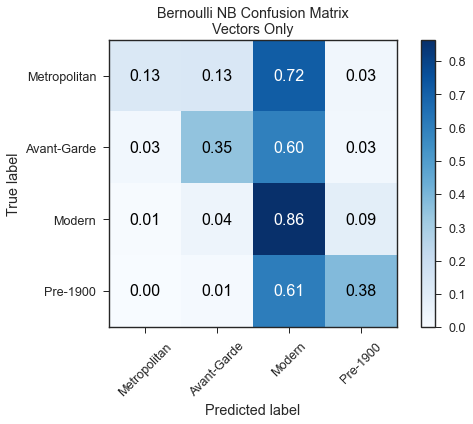

In [168]:
# plot confusion matrix - normalized
cm_benaba = confusion_matrix(y_test2, y_test_preds_bnb_vec)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(cm_benaba, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix\nVectors Only', cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/bnb_vec_cm.png', transparent=True, bbox_inches='tight', dpi=100)

### Vectors + numerical data

In [169]:
%%time

# instantiate the naive bayes classifier
benaba_combo = BernoulliNB()

# fit it to our training set
benaba_combo.fit(X_train_combo2, y_train2)

CPU times: user 12.4 s, sys: 2.53 s, total: 14.9 s
Wall time: 14.5 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [170]:
%%time

# predict the new document from the testing dataset
y_train_preds_bnb_combo = benaba_combo.predict(X_train_combo2)
y_test_preds_bnb_combo = benaba_combo.predict(X_test_combo2)

# print out accuracy and f1 scores for train set
benaba_combo_acc_train = accuracy_score(y_train, y_train_preds_bnb_combo)
benaba_combo_f1_train = f1_score(y_train, y_train_preds_bnb_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {benaba_combo_acc_train}')
print(f'F1 score: {benaba_combo_f1_train}')

# print out accuracy and f1 scores for test set
benaba_combo_acc_test = accuracy_score(y_test, y_test_preds_bnb_combo)
benaba_combo_f1_test = f1_score(y_test, y_test_preds_bnb_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {benaba_combo_acc_test}')
print(f'F1 score: {benaba_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_bnb_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_bnb_combo))

-----TRAIN-----
Accuracy: 0.6684210526315789
F1 score: 0.6751999282476966

-----TEST-----
Accuracy: 0.4586815227483751
F1 score: 0.4296462820371316

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

metropolitan       0.74      0.13      0.22       239
 avant_garde       0.66      0.35      0.46       268
      modern       0.36      0.86      0.51       311
    pre_1900       0.71      0.38      0.50       259

    accuracy                           0.46      1077
   macro avg       0.62      0.43      0.42      1077
weighted avg       0.60      0.46      0.43      1077


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[ 31  32 169   7]
 [  9  95 158   6]
 [  2  13 269  27]
 [  0   3 157  99]]
CPU times: user 16.6 s, sys: 2.97 s, total: 19.6 s
Wall time: 18.3 s


- Practically the same result; a very slight boost if anything.

#### Confusion matrix

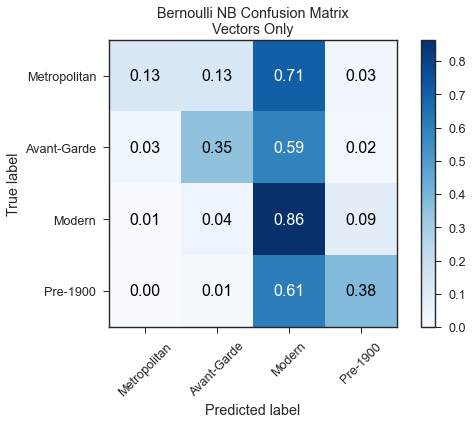

In [171]:
# plot confusion matrix - normalized
cm = confusion_matrix(y_test, y_test_preds_bnb_combo)
classes = ['Metropolitan', 'Avant-Garde', 'Modern', 'Pre-1900']
plot_confusion_matrix(cm, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix\nVectors Only', cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/bnb_combo_cm.png', transparent=True, bbox_inches='tight', dpi=100)

- This confirms it is practically the same, with a slightly better accuracy at predicting Metropolitan.

#### Feature importances

In [172]:
# function to print top 10 features for each class
print_nb_features(
            benaba_combo,
            X_train_combo2,
            ['metropolitan', 'avant_garde', 'modern', 'pre_1900']
        )

Metropolitan tweets:
zz, slackend, impending, impend, impels, slackened, impediment, impedes, slackening, impede

Avant-Garde tweets:
lengthwise, modestly, modernest, moderately, moderate, modelled, mod, mocks, mockingbirds, mockingbird

Modern tweets:
lengthwise, hazel, hazed, hazards, scraping, hazarded, scrappy, hazan, hayworth, haystraw

Pre-1900 tweets:
lengthwise, milkpitcher, milkman, milker, militarisme, militant, milieus, milieu, miliar, milholland



- **The number of words per line dropped down, but still in the top ten.**

# Modeling conclusions
- **Form/structure is important for prediction (especially Random Forest models).**
    - **Further exploration desired:**
        - **Other types of rhyme**
        - **Use of line breaks, tabs, and spacing**
        - **Topic modeling**
- **SVM relies mostly on vocabulary.**
    - **Further exploration desired:**
        - **Word embeddings (self-trained and pre-trained)**
        - **POS tagging**
- **SVM is the best model!**